# SNR Calculations
This notebook is used to calculate SNRs and optimum aperture diameters

In [1]:
from astropy.io import fits
import Transmission_calculation as trans
from astropy import units as u
import numpy as np
import math
from astropy.modeling.functional_models import Disk2D
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling.models import Moffat2D
plt.style.use('bmh')

In [2]:
def numerical_durham(diameter,wavelength,offset,axis_val=24,version=0):
    file=fits.open("PSFs/GLAO_Median_{}nm_v2.fits".format(round(wavelength.value)))
    durham_data=file[version].data[axis_val]
    scale=file[version].header['scale']

    fibre_boundary=math.ceil(diameter.value/2/scale)
    data_boundary=len(durham_data)

    x = np.arange(-fibre_boundary,fibre_boundary+1)
    y = np.arange(-fibre_boundary, fibre_boundary+1)
    x, y = np.meshgrid(x, y)

    offset = abs(offset)
    disk=Disk2D(1,abs(int(offset.value/scale)-offset.value/scale),0,diameter.value/2/scale)
    disk_data=disk(x,y)

    resized_data=np.zeros([len(disk_data),len(disk_data)])

    durham_data=durham_data[int(data_boundary/2-fibre_boundary):int(data_boundary/2+fibre_boundary)+1,int(data_boundary/2-fibre_boundary+offset.value/scale):int(data_boundary/2+fibre_boundary+offset.value/scale)+1]
    resized_data[0:len(durham_data),0:len(durham_data[0])]=durham_data

    convolved=resized_data*disk_data
    trans=sum(sum(convolved))
    return trans

def numerical_durham_slow(diameter,wavelength,shift,axis_val=24):
    file=fits.open("PSFs/GLAO_Median_{}nm.fits".format(round(wavelength.value)))
    durham_data=file['PRIMARY'].data[axis_val]
    scale=file[0].header['scale']
    
    boundary=len(durham_data)

    x = np.arange(0, boundary)
    y = np.arange(0, boundary)
    x, y = np.meshgrid(x, y)

    Disk=Disk2D(1,boundary/2,boundary/2,diameter.value/2/scale)
    Disk_data=Disk(x,y)

    convolved_data=durham_data*Disk_data
    trans=sum(sum(convolved_data))
    
    return trans

def SNRs(diameters,FWHM=0,wavelength=0,method="analytical"):
    if method=="analytical":
        SNR_vals=trans.analytical_gaussian(diameters*u.arcsec,FWHM*u.arcsec,0*u.arcsec,k_lim=100)/diameters
    if method=="moffat":
        SNR_vals=[]
        for diameter in diameters:
            SNR_vals.append(trans.numerical_moffat(diameter*u.arcsec,FWHM*u.arcsec,0*u.arcsec,beta=2.5,scale=0.01)/diameter)
    if method=="gaussian":
        SNR_vals=[]
        for diameter in diameters:
            SNR_vals.append(trans.numerical_gaussian(diameter*u.arcsec,FWHM*u.arcsec,0*u.arcsec,scale=0.01)/diameter)
    if method=="durham":
        SNR_vals=[]
        for diameter in diameters:
            SNR_vals.append(numerical_durham(diameter,wavelength,0)/diameter)
    return SNR_vals

def find_d_opt(d_range, SNRs,fraction):
    one_index=list(SNRs).index(1)
    min_index=abs(SNRs[0:one_index+1]-fraction).argmin()
    return d_range[min_index],SNRs[min_index]

## SNR vs d/FWHM
### Gaussian, Moffat, and Durham

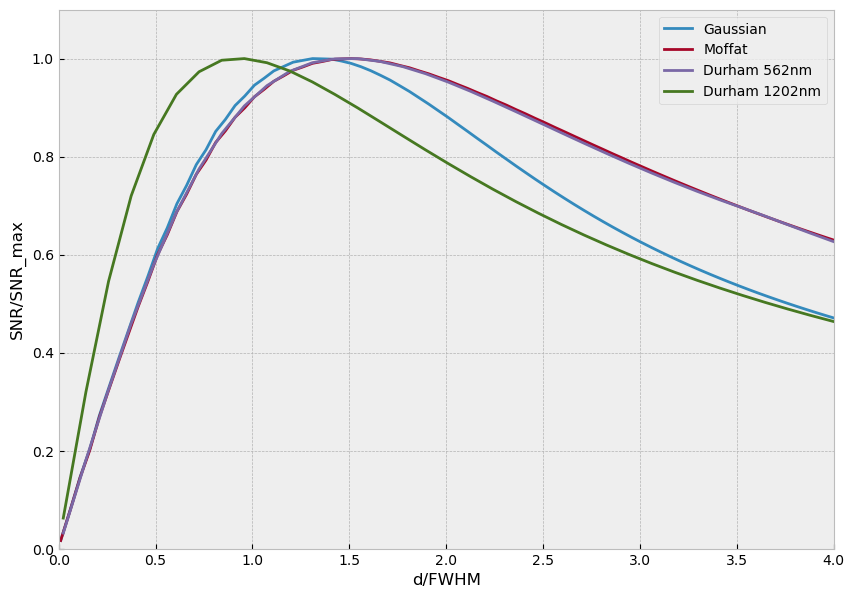

In [3]:
d=np.arange(0.01,4.1,.05)
FWHM=1

anal_vals=SNRs(d,FWHM,method="analytical")
gaus_vals=SNRs(d,FWHM,method="gaussian")
moff_vals=SNRs(d,FWHM,method="moffat")

plt.figure(figsize=[10,7])
plt.plot(d/FWHM,gaus_vals/max(gaus_vals),label="Gaussian")
plt.plot(d/FWHM,moff_vals/max(moff_vals),label="Moffat")
plt.ylabel("SNR/SNR_max")
plt.xlabel("d/FWHM")

plt.xlim(0,4)
plt.ylim(0,1.1)
SNR_vals=[]
for diameter in d:
    SNR_vals.append(numerical_durham_slow(diameter*u.arcsec,562*u.micron,0*u.arcsec)/diameter)
plt.plot(d/0.428,SNR_vals/max(SNR_vals),label="Durham 562nm")

SNR_vals=[]
for diameter in d:
    SNR_vals.append(numerical_durham_slow(diameter*u.arcsec,1202*u.micron,0*u.arcsec)/diameter)
plt.plot(d/0.428,SNR_vals/max(SNR_vals),label="Durham 1202nm")

plt.legend()


### Durham with various Axis Vals

In [4]:
def numerical_moffat(fibre_diameter,FWHM,offset,scale,beta=2.5):
    """
    Calculates transmission of Moffat PSF offset from a circular aperture
    Numerical solution

    INPUTS:
    fibre_diameter: float, astropy units
        diameter of the fibre/aperture
    FWHM: float, astropy units
        FWHM of the PSF
    offset: float, astropy units
        offset of the PSF from the aperture
    scale: float
        scale of the numerical simulation, arcsec/pixel
    beta: float
        power index of the moffat equation, (also known as atmospheric scattering coefficient)

    OUTPUTS:
    Returns:
    transmission: float
        transmission value
    """
    alpha=FWHM.value/scale/(2*np.sqrt(2**(1/beta)-1))

    moffat_total=(np.pi*alpha**2)/(beta-1)

    x_pos=offset/scale  

    boundary=math.ceil(fibre_diameter.value/2/scale)

    x = np.arange(-boundary, boundary+1)
    y = np.arange(-boundary, boundary+1)
    x, y = np.meshgrid(x, y)

    Disk=Disk2D(1,0,0,fibre_diameter.value/2/scale)
    Disk_data=Disk(x,y)
    Moffat=Moffat2D(1,x_pos.value,0,alpha,beta)
    Moffat_data=Moffat(x,y)

    convolved_data=Disk_data*Moffat_data

    trans=sum(sum(convolved_data))/moffat_total
    return trans


In [5]:
d_range=np.arange(0.01,2.01,0.01)*u.arcsec
wavelength_range=[440,562,720,920,1202,1638]*u.micron

In [6]:
SNR_wavelength_comb=[] #first index is wavelength, second is axis alignment
trans_wavelength_comb=[]
for wavelength in wavelength_range:
    SNR_axis_comb=[]
    trans_axis_comb=[]
    for i in range(0,49):
        SNRs=[]
        trans_vals=[]
        for d in d_range:
            trans_val=numerical_durham_slow(d,wavelength,0*u.arcsec,i)
            trans_vals.append(trans_val)
            SNRs.append(trans_val/d.value)

        SNR_axis_comb.append(SNRs/max(SNRs))
        trans_axis_comb.append(trans_vals)
    SNR_wavelength_comb.append(SNR_axis_comb)
    trans_wavelength_comb.append(trans_axis_comb)
    
d_range=np.arange(0.01,2.01,0.01)*u.arcsec
wavelength_range=[440,562,720,920,1202,1638]*u.micron
FWHMs=[]
for wavelength in wavelength_range:
    FWHMs.append(trans.calculate_FWHM(wavelength,1,.68*u.arcsec,500*u.nm))


SNR_wavelength_comb2=[]
trans_wavelength_comb2=[]
for FWHM in FWHMs:
    SNRs=[]
    trans_vals=[]
    for d in d_range:
       
        trans_val=trans.numerical_moffat(d,FWHM,0*u.arcsec,0.01)
        trans_vals.append(trans_val)
        SNRs.append(trans_val/d.value)

    SNR_wavelength_comb2.append(SNRs/max(SNRs))
    trans_wavelength_comb2.append(trans_vals)


d_range=np.arange(0.01,2.01,0.01)*u.arcsec
wavelength_range=[440,562,720,920,1202,1638]*u.micron
FWHMs=[]
for wavelength in wavelength_range:
    FWHMs.append(trans.calculate_FWHM(wavelength,2,.68*u.arcsec,500*u.nm))


SNR_wavelength_comb3=[]
trans_wavelength_comb3=[]
for FWHM in FWHMs:
    SNRs=[]
    trans_vals=[]
    for d in d_range:
       
        trans_val=trans.numerical_moffat(d,FWHM,0*u.arcsec,0.01)
        trans_vals.append(trans_val)
        SNRs.append(trans_val/d.value)

    SNR_wavelength_comb3.append(SNRs/max(SNRs))
    trans_wavelength_comb3.append(trans_vals)


In [7]:
fraction=1
d_opt_comb=[] #first index is wavelength, second is axis alignment
for SNR_vals in SNR_wavelength_comb:
    d_opt=[]
    for i in range(0,49):
        d_opt_val,void=find_d_opt(d_range.value,SNR_vals[i],fraction)
        d_opt.append(d_opt_val)
    d_opt_comb.append(d_opt)

Text(0.5, 1.0, '0.44 micron Durham PSF')

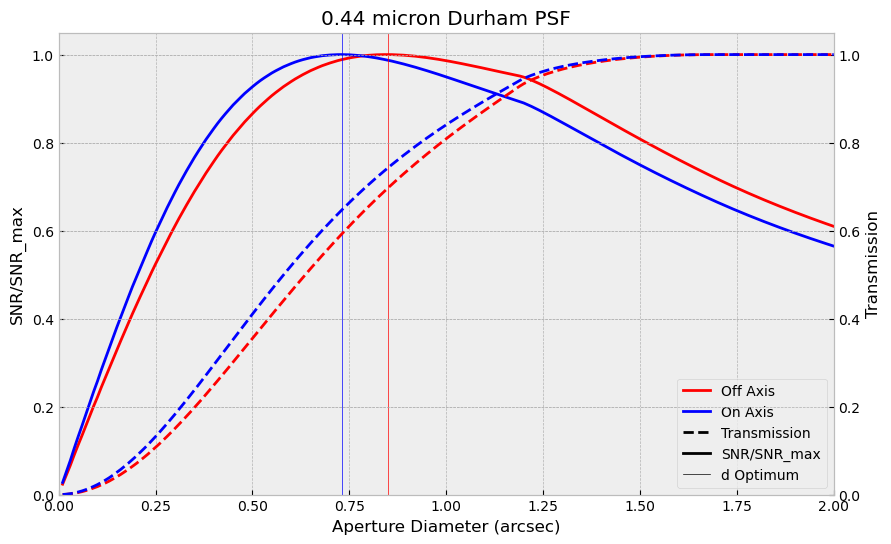

In [8]:
i=0
fig, ax1 = plt.subplots(figsize=[10,6])
ax2=ax1.twinx()

ax1.plot(d_range,SNR_wavelength_comb[i][0],color='red',label="Off Axis")
ax1.plot(d_range,SNR_wavelength_comb[i][24],color='blue',label="On Axis")

ax2.plot(d_range,trans_wavelength_comb[i][0],linestyle='--',color='red')
ax2.plot(d_range,trans_wavelength_comb[i][24],linestyle='--',color='blue')

ax1.axhline(-1,linestyle='--',label="Transmission",color='black')
ax1.axhline(-1,label="SNR/SNR_max",color='black')
ax1.axhline(-1,color='black',linewidth=0.5,label="d Optimum")

ax1.axvline(d_opt_comb[i][0],linewidth=0.5,color='red')
ax1.axvline(d_opt_comb[i][24],linewidth=0.5,color='blue')

ax1.set_xlabel("Aperture Diameter (arcsec)")
ax1.set_ylabel("SNR/SNR_max")
ax2.set_ylabel("Transmission")
ax1.legend(loc=4)

ax1.set_ybound(0,1.05)
ax2.set_ybound(0,1.05)
plt.xlim(0,2)
plt.title("{} Durham PSF".format(wavelength_range[i]/1000))

#The high d transmission=0 bug is caused by the method; basically a fibre that is bigger than the PSF file causes the cropping to go haywire. Use the slow method instead

Text(0.5, 1.0, '1.638 micron Durham PSF')

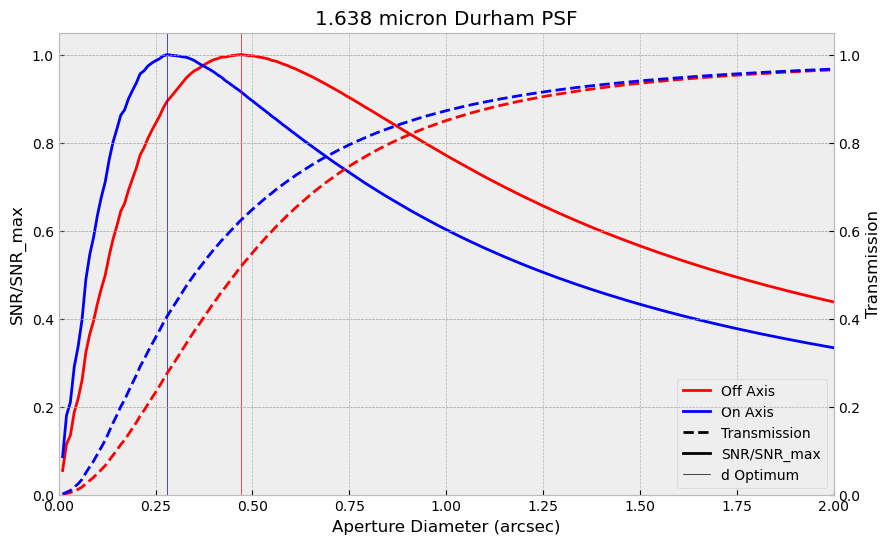

In [9]:
i=-1
fig, ax1 = plt.subplots(figsize=[10,6])
ax2=ax1.twinx()

ax1.plot(d_range,SNR_wavelength_comb[i][0],color='red',label="Off Axis")
ax1.plot(d_range,SNR_wavelength_comb[i][24],color='blue',label="On Axis")

ax2.plot(d_range,trans_wavelength_comb[i][0],linestyle='--',color='red')
ax2.plot(d_range,trans_wavelength_comb[i][24],linestyle='--',color='blue')

ax1.axhline(-1,linestyle='--',label="Transmission",color='black')
ax1.axhline(-1,label="SNR/SNR_max",color='black')
ax1.axhline(-1,color='black',linewidth=0.5,label="d Optimum")

ax1.axvline(d_opt_comb[i][0],linewidth=0.5,color='red')
ax1.axvline(d_opt_comb[i][24],linewidth=0.5,color='blue')

ax1.set_xlabel("Aperture Diameter (arcsec)")
ax1.set_ylabel("SNR/SNR_max")
ax2.set_ylabel("Transmission")
ax1.legend(loc=4)

ax1.set_ybound(0,1.05)
ax2.set_ybound(0,1.05)
plt.xlim(0,2)
plt.title("{} Durham PSF".format(wavelength_range[i]/1000))

## Optimum Aperture Diameter
Violin plot of optimum aperture diameter for the various Durham PSFs

Text(0.5, 1.0, 'Optimum Aperture, Fraction of Max SNR = 0.9')

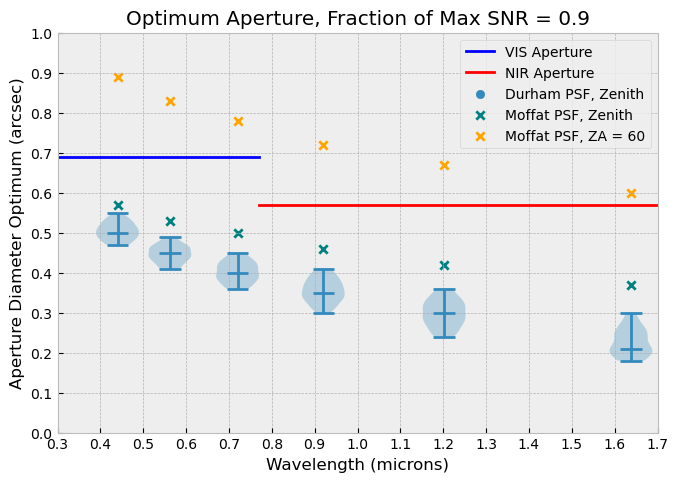

In [10]:
fraction=.9
d_opt_comb=[] #first index is wavelength, second is axis alignment
for SNR_vals in SNR_wavelength_comb:
    d_opt=[]
    for i in range(0,49):
        d_opt_val,void=find_d_opt(d_range.value,SNR_vals[i],fraction)
        d_opt.append(d_opt_val)
    d_opt_comb.append(d_opt)
    
fig=plt.figure(figsize=[6,4])
ax=fig.add_axes([0,0,1,1])
plt.axhline(y=0.69,xmin=0,xmax=0.3357,label="VIS Aperture",color='blue')
plt.axhline(y=0.57,xmin=0.3357,xmax=1,label="NIR Aperture",color='red')
bp= ax.violinplot(d_opt_comb,positions=np.array(wavelength_range)/1000,widths=0.1,showmedians=True)
plt.ylim(0,1)
plt.xlim(0.3,1.7)
plt.ylabel("Aperture Diameter Optimum (arcsec)")
plt.xlabel("Wavelength (microns)")
plt.scatter(0,0,label='Durham PSF, Zenith')
plt.yticks(np.arange(0,1.1,.1))
plt.xticks(np.arange(0.3,1.8,0.1))



fraction=.9
d_opt_comb=[] #first index is wavelength, second is axis alignment
for SNR_vals2 in SNR_wavelength_comb2:
    d_opt=[]

    d_opt_val,void=find_d_opt(d_range.value,SNR_vals2,fraction)
    d_opt.append(d_opt_val)
    d_opt_comb.append(d_opt)
    
for count,value in enumerate(d_opt_comb):
    ax.scatter(wavelength_range[count]/1000,value,marker='x',color='teal')
ax.scatter(0,0,color='teal',label='Moffat PSF, Zenith',marker='x')

plt.legend()
plt.title("Optimum Aperture Fraction of Max SNR = {}".format(fraction))

fraction=.9
d_opt_comb=[] #first index is wavelength, second is axis alignment
for SNR_vals3 in SNR_wavelength_comb3:
    d_opt=[]

    d_opt_val,void=find_d_opt(d_range.value,SNR_vals3,fraction)
    d_opt.append(d_opt_val)
    d_opt_comb.append(d_opt)
    
for count,value in enumerate(d_opt_comb):
    ax.scatter(wavelength_range[count]/1000,value,marker='x',color='orange')
ax.scatter(0,0,color='orange',label='Moffat PSF, ZA = 60',marker='x')

plt.legend()
plt.title("Optimum Aperture, Fraction of Max SNR = {}".format(fraction))

Text(0.5, 1.0, 'Optimum Aperture, Fraction of Max SNR = 1')

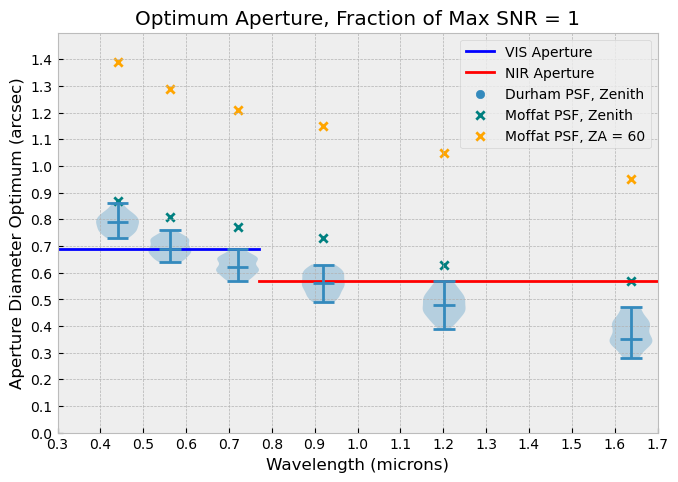

In [12]:
fraction=1
d_opt_comb=[] #first index is wavelength, second is axis alignment
for SNR_vals in SNR_wavelength_comb:
    d_opt=[]
    for i in range(0,49):
        d_opt_val,void=find_d_opt(d_range.value,SNR_vals[i],fraction)
        d_opt.append(d_opt_val)
    d_opt_comb.append(d_opt)
    
fig=plt.figure(figsize=[6,4])
ax=fig.add_axes([0,0,1,1])
plt.axhline(y=0.69,xmin=0,xmax=0.3357,label="VIS Aperture",color='blue')
plt.axhline(y=0.57,xmin=0.3357,xmax=1,label="NIR Aperture",color='red')
bp= ax.violinplot(d_opt_comb,positions=np.array(wavelength_range)/1000,widths=0.1,showmedians=True)
plt.ylim(0,1.5)
plt.xlim(0.3,1.7)
plt.ylabel("Aperture Diameter Optimum (arcsec)")
plt.xlabel("Wavelength (microns)")
plt.scatter(0,0,label='Durham PSF, Zenith')
plt.yticks(np.arange(0,1.5,.1))
plt.xticks(np.arange(0.3,1.8,0.1))



fraction=1
d_opt_comb=[] #first index is wavelength, second is axis alignment
for SNR_vals2 in SNR_wavelength_comb2:
    d_opt=[]

    d_opt_val,void=find_d_opt(d_range.value,SNR_vals2,fraction)
    d_opt.append(d_opt_val)
    d_opt_comb.append(d_opt)
    
for count,value in enumerate(d_opt_comb):
    ax.scatter(wavelength_range[count]/1000,value,marker='x',color='teal')
ax.scatter(0,0,color='teal',label='Moffat PSF, Zenith',marker='x')


fraction=1
d_opt_comb=[] #first index is wavelength, second is axis alignment
for SNR_vals3 in SNR_wavelength_comb3:
    d_opt=[]

    d_opt_val,void=find_d_opt(d_range.value,SNR_vals3,fraction)
    d_opt.append(d_opt_val)
    d_opt_comb.append(d_opt)
    
for count,value in enumerate(d_opt_comb):
    ax.scatter(wavelength_range[count]/1000,value,marker='x',color='orange')
ax.scatter(0,0,color='orange',label='Moffat PSF, ZA = 60',marker='x')

plt.legend()
plt.title("Optimum Aperture, Fraction of Max SNR = {}".format(fraction))